
📍 용산구 지역 30일 예측 시작

[용산구 - co] 예측 시작


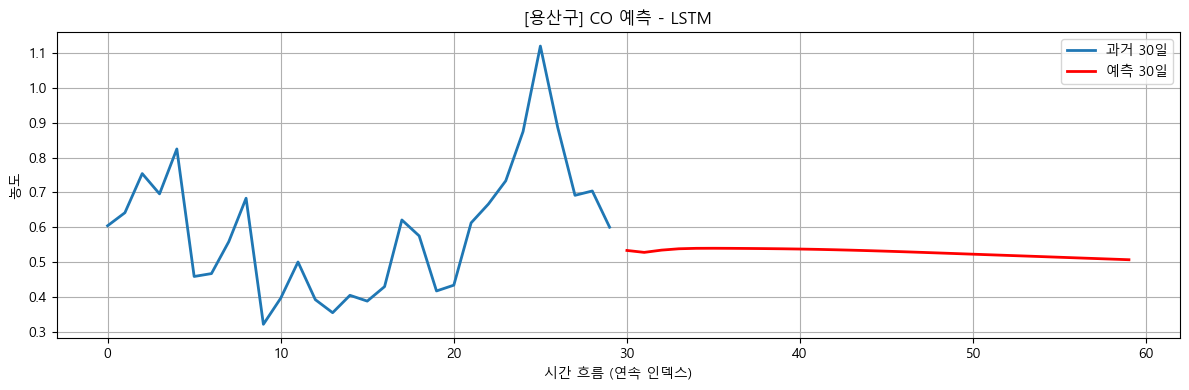


[용산구 - so2] 예측 시작


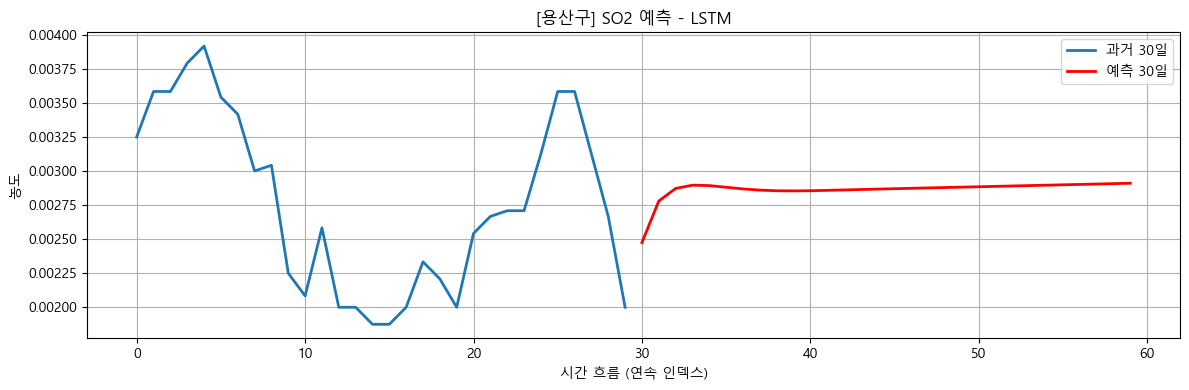


[용산구 - no2] 예측 시작


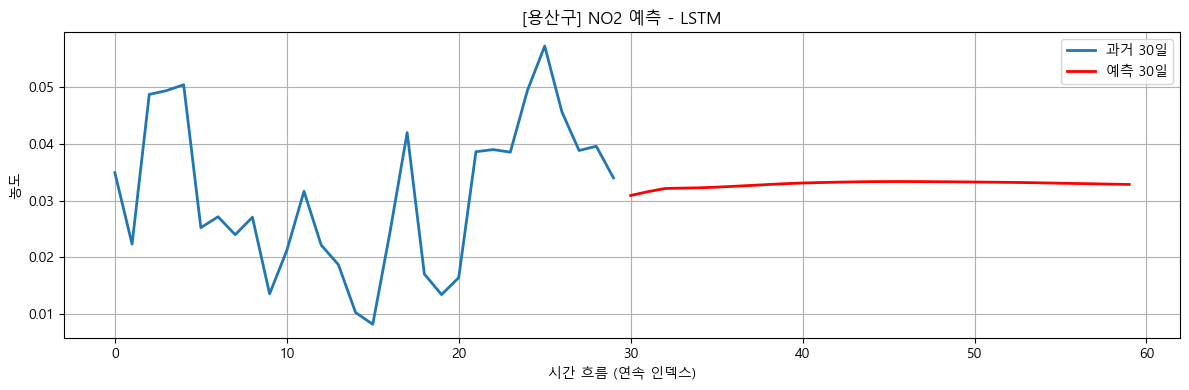


[용산구 - o3] 예측 시작


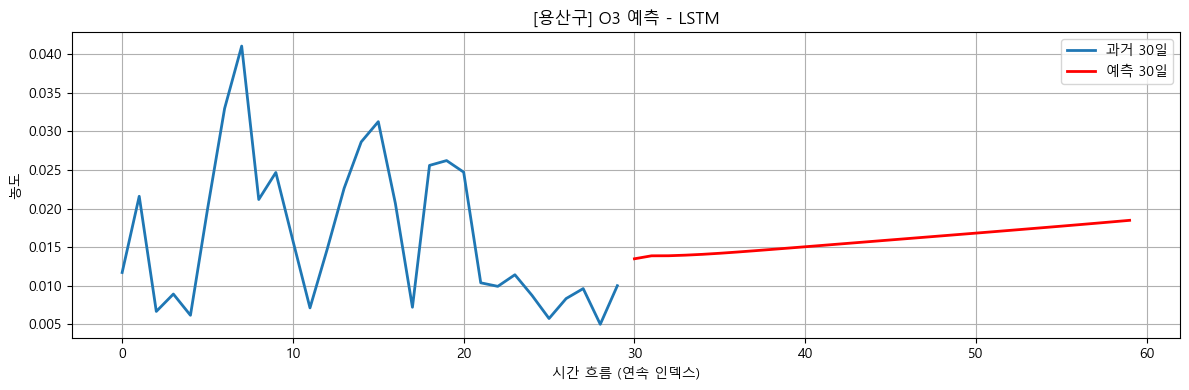

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['font.family'] = 'MALGUN GOTHIC'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/대기오염물질_데이터셋.csv", encoding="UTF-8")
df = df[['datetime', 'region', 'co', 'so2', 'no2', 'o3']]

# 전처리 및 시퀀스 생성 함수
def create_sequences(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

def prepare_series(df, region, pollutant):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[df['region'] == region].copy()
    df.set_index('datetime', inplace=True)
    series = df[pollutant].resample('d').mean().interpolate(method='spline', order=3)
    return series.dropna()

def forecast_future_lstm(series, region, pollutant, days=30):
    print(f"\n[{region} - {pollutant}] 예측 시작")

    series.index = pd.to_datetime(series.index)
    series = series.sort_index()

    if len(series) < 100:
        print(f"[{region} - {pollutant}] 데이터 부족 (<100일)")
        return None, None

    df_values = pd.DataFrame(series)
    scaler = RobustScaler()
    scaled = scaler.fit_transform(df_values)

    X, y = create_sequences(scaled, window_size=48)
    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]

    model = Sequential([
        Input(shape=(48, X.shape[2])),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

    # 미래 예측
    last_seq = scaled[-48:].reshape(1, 48, X.shape[2])
    future_scaled = []

    for _ in range(days):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        future_scaled.append([next_pred])
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    padded = np.hstack([np.array(future_scaled), np.zeros((days, X.shape[2] - 1))])
    future_inv = scaler.inverse_transform(padded)[:, 0]

    today = pd.Timestamp('2025-07-03')
    future_dates = pd.date_range(start=today + pd.Timedelta(days=1), periods=days)

    # 시각화
    past_values = series[-30:].values
    combined = np.concatenate([past_values, future_inv])
    x = range(len(combined))

    plt.figure(figsize=(12, 4))
    plt.plot(x[:30], past_values, label="과거 30일", linewidth=2)
    plt.plot(x[30:], future_inv, label="예측 30일", color='red', linewidth=2)
    plt.title(f"[{region}] {pollutant.upper()} 예측 - LSTM")
    plt.xlabel("시간 흐름 (연속 인덱스)")
    plt.ylabel("농도")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({'date': future_dates, 'predicted_value': future_inv}), model

# 전체 예측 실행
def forecast_region_all_pollutants(df, region, days=30):
    pollutants = ['co', 'so2', 'no2', 'o3']
    results = {}

    print(f"\n📍 {region} 지역 {days}일 예측 시작")

    for pollutant in pollutants:
        series = prepare_series(df.copy(), region, pollutant)
        pred_df, model = forecast_future_lstm(series, region, pollutant, days=days)

        if pred_df is not None:
            results[pollutant] = pred_df
        else:
            print(f"[{pollutant}] 예측 실패 또는 데이터 부족")

    return results

# 실행
results = forecast_region_all_pollutants(df, region='용산구', days=30)